$$ \LaTeX \text{ command declarations here.}
\newcommand{\N}{\mathcal{N}}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|_2}
\newcommand{\d}{\mathop{}\!\mathrm{d}}
\newcommand{\qed}{\qquad \mathbf{Q.E.D.}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vt}{\mathbf{t}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vm}{\mathbf{m}}
\newcommand{\I}{\mathbb{I}}
\newcommand{\th}{\text{th}}
$$

In [1]:
%matplotlib inline
from Lec08 import *

# EECS 445:  Machine Learning
## Lecture 08:  Support Vector Machines
* Instructor:  **Jacob Abernethy** and **Jia Deng**
* Date:  Oct 3, 2016

*Lecture Exposition Credit: Ben, Saket, & Valli*

## Outline

- Prerequisite

- Maximum Margin Classifier
    - Problem Formulation
    - Linear Separability
    - Optimal Soft Margin Hyperplane (OSMH)

- Duality
    - Concepts
    - KKT Conditions

- Optimal Soft Margin Hyperplane
    - Dual Problem Formulation    
    - Support Vectors
    - Kernelization and SVM
    

## Reading List

- Suggested:
    - **[PRML]**, §7.1: Maximum Margin Classifiers

- Optional:    
    - **[CS229]**, Lecture Notes 03: [Support Vector Machines & Kernels](http://cs229.stanford.edu/notes/cs229-notes3.pdf)

> In this lecture, we will introduce a classifier with heuristical idea, which is finding a separating hyperplane such that the distance from any datapoint to it is maximized. This classifier is called *maximum margin classifier*. The parameter of this classifier can be obtained by solving a simple optimization problem. The disadvantage of maximum margin classifier is that it doesn't work for dataset that is not linearly separable. To deal with this, we will do some slackness and convert original optimal hard margin hyperplane problem into *optimal soft margin hyperplane (OSMH)* problem. Instead of solving OSMH problem directly, we will show how to solve it by solving its dual problem. This can be advantageous because sometimes dual problem can be easier to solve than original problem. Don't be afraid if you don't have much knowledge about convex duality, some basics of duality will be reviewed. With these knowledge, we will show how to formulate the dual problem and how to obtain primal solution out of dual solution. Then, some analysis about support vectors will be proposed both analytically and geometrically. Finally, how to apply kernel trick to our classifier is shown. This is critical because kernel can map original feature into some higher dimensional feature space just like we talked about in last lecture.

## Preliminaries

### Vapnik's Principle:

> "When solving a problem of interest, do not solve a more general problem as an intermediate step."

> "Don't solve a harder problem than you have to" 

### Review:  Linear Classifiers

- Linear classifiers make decisions based on a linear (or more generally affine) combination of features.
    - *Generative*: Require estimation of (conditional) densities or mass functions.
        - Naive Bayes
    - *Discriminative*: Often much easier to just determine the "decision boundary."
        - Logistic Regression, Perceptron

- Based on *Vapnik's Principle*, we will focus on a discriminative classifer **Support Vector Machine (SVM)**  in this lecture.

### Preliminaries: Hyperplane

- **Hyperplane** is an affine subspace one dimension fewer than its ambient space.
    - The hyperplanes of a 2-D space are 1-D lines.
    - The hyperplanes of a 3-D space are 2-D planes.
    
- Mathematically, a **hyperplane** is of the form 
    $$
    \mathbb{H} = \{\vx : \vw^T\vx + b = 0\}
    $$ 
    where $\mathbf{w} \in \mathbb{R}^d$, $b \in \mathbb{R}$ and $d$ is the number of features.
       

### Preliminaries: Point-Plane Distance

- Given a hyperplane $\mathbb{H} = \{\mathbf{x} : \mathbf{w}^T\mathbf{x} + b = 0\}$ and a point $\mathbf{z} \not \in \mathbb{H}$, what is the point-plane distance from $\mathbf{z}$ to $\mathbb{H}$?

- We can write $\mathbf{z}$ as:        
    $$
    \mathbf{z} = \mathbf{z}_0 + r \cdot \frac{\mathbf{w}}{\| \mathbf{w} \|}
    $$
    
- We have decomposed $\mathbf{z}$ into two components:
    $$
    \mathbf{z}_0 \in \mathbb{H} \qquad r \frac{\mathbf{w}}{\| \mathbf{w} \|} \perp \mathbb{H}
    $$
    <center> <img src="images/pointplanedistance.png"  style="width:200px;height:150px;"> </center>
    
- So the distance is then given by $|r|$!


### Preliminaries: Point-Plane Distance

- Calculating $|r|$:
    $$\begin{split}
    \vw^T\mathbf{z} + b 
    &= \vw^T \left(\mathbf{z}_0 + r \cdot \frac{\mathbf{w}}{\| \mathbf{w} \|} \right) + b \\
    &= \underbrace{\mathbf{w}^T\mathbf{z}_0 +b}_{=0}+ \vw^T \left(r \cdot \frac{\vw}{\| \vw \| }\right) \\
    &= r \frac{\vw^T\vw}{\| \vw \|} \\
    &= r \|\vw \|  \\
    \end{split}
    $$
    Therefore, point-plane distance from point $\mathbf{z}$ to plane $\{\mathbf{x} : \mathbf{w}^T\mathbf{x} + b = 0\}$ is
    $$
    \boxed{|r| = \frac{|\vw^T \mathbf{z} + b|}{\|\vw\|}}
    $$


### Preliminaries

- **Separating Hyperplanes**
    - Provide a way of solving 2-class classification problems.

    - **Idea:** divide the vector space $\mathbb{R}^d$ where $d$ is the number of features into 2 "decision regions" with a $\mathbb{R}^{d - 1}$  subspace (a hyperplane).
        - Eg. Logistic Regression
    
    - As with other linear classifiers, classification could be achieved by
        $$
        y = \text{sign}(\vw^T\vx + b)
        $$
        **Note:** We may use $\vx$ and $\phi(\vx)$ interchangeably to denote features.
    
- **(Functional) Margin**
    - The distance from a separating hyperplane to the *closest* datapoint of *any* class.    
        $$
        \rho
        = \rho(\vw, b) 
        = \min_{i = 1, ..., n} \frac{| \vw^T\vx_i + b |}{\| \vw \|}
        $$
        where $\mathbf{x}_i$ is the $i$th datapoint from the training set.

## Maximum Margin Classifier

### Maximum Margin Classifier
- **Max. Margin Classifiers:** separate data by looking for the hyperplane that maximizes the margin.

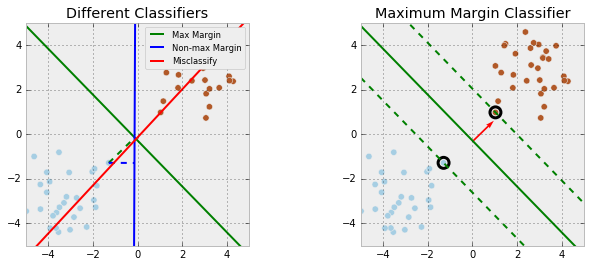

In [2]:
plot_svc();

- The length of dotted segment in left plot is margin $\rho$.
- Properties  
    - tends to guarantee better generalization performance.
    - more robust to noise
    - misclassification unlikely with a wide margin between classes.

### Finding the Max-Margin Hyperplane

- For dataset $\{\vx_i, t_i \}_{i=1}^n $, maximum margin separating hyperplane is the solution of
    $$
    \begin{split}
    \underset{\vw, b}{\text{maximize}} \quad & \min_{i = 1, ..., n} \frac{| \vw^T\vx_i + b |}{\| \vw \|}\\
    \text{subject to} \quad & t_i(\vw^T \vx_i + b) > 0  \quad \forall i \\
    \end{split}
    $$
    of which the constraint ensures every training data is correctly classified
    -  Note that $t_i \in \{+1, -1\}$ is the label of $i$th training data
    
- This problem guarantees optimal hyperplane, but the solution $\vw$ and $b$ is **not** unique :
    - we could scale both $\vw$ and $b$ by arbitrary scalar without affecting $\mathbb{H} = \{\vx : \vw^T\vx + b = 0\}$
    - we have infinite sets of solutions

### Ensuring Uniqueness of Solution
- For the optimal hyperplane $\mathbf{H}$ and *one* set of $\vw$ and $b$, let 
    $$
    m=\underset{i = 1, ..., n}{\min} \left| \vw^T\vx_i + b \right|
    $$
- If we scale $\vw$ and $b$ by $\frac{1}{m}$, we could get a new and unique set of $\vw$ and $b$ such that
    - $\underset{i = 1, ..., n}{\min} \left| \vw^T\vx_i + b \right|=1$ and margin becomes $\frac{1}{\| \vw \|}$
    - $t_i(\vw^T \vx_i + b) = 1$ for some $i$ and $t_i(\vw^T \vx_i + b) > 1$ for other $i$'s
- So, conversely, if we restrict $t_i(\vw^T \vx_i + b) = 1$ for some $i$ and $t_i(\vw^T \vx_i + b) > 1$ for other $i$'s, we have
    - $\underset{i = 1, ..., n}{\min} \left| \vw^T\vx_i + b \right|=1$ and margin becomes $\frac{1}{\| \vw \|}$
    - problem will have *unique* solution $\vw$ and $b$
- Original problem can be converted into
    $$
    \begin{split}
    \underset{\vw, b}{\text{maximize}} \quad & \min_{i = 1, ..., n} \frac{| \vw^T\vx_i + b |}{\| \vw \|}\\
    \text{subject to} \quad & t_i(\vw^Tx_i + b) > 0  \quad \forall i \\
    \quad
    \end{split}
    \Longrightarrow
    \begin{split}
    \underset{\vw, b}{\text{maximize}} \quad & \frac{1}{\| \vw \|}\\
    \text{subject to} \quad & t_i(\vw^T \vx_i + b) = 1 \quad \text{ for some } i\\
     \quad & t_i(\vw^T \vx_i + b) > 1 \quad \text{ for other } i\\
    \end{split}
    $$

### Restatement of Optimization Problem

- Simplifying further, we have 
    $$
    \begin{split}
    \underset{\vw, b}{\text{maximize}} \quad & \frac{1}{\| \vw \|}\\
    \text{subject to} \quad & t_i(\vw^T \vx_i + b) = 1 \text{ for some } i\\
     \quad & t_i(\vw^T \vx_i + b) > 1  \text{ for other } i\\
    \end{split}
    \Longrightarrow
    \begin{split}
    \underset{\vw, b}{\text{minimize}} \quad & \frac{1}{2}{\| \vw \|}^2\\\
    \text{subject to} \quad & t_i(\vw^T \vx_i + b) \geq 1 \quad \forall i \\
    \quad
    \end{split}
    $$


### Linear Separability

- Two classes of data are said to be **linearly separable** if there exists a hyperplane that separates them without any errors.
- So far, we have looked at primarily linearly separable data where a single hyperplane will do for classification.
- We can extend on this notion to a multiclass scenario by considering data to be linearly separable if there exists a set of hyperplanes that can classify each class of examples from the rest (again without errors).
- **BUT**, how to deal with data that **aren't** linearly separable?
    - Use "slack" variables that allow for misclassification and penalize misclassification.
        - This is the protagonist of this lecture.
        - Hyperplane obtained in this way is called **optimal soft-margin hyperplane (OSMH)**
    - Extend linear classifiers with kernels.

### Optimal Soft-Margin Hyperplane (OSMH)

- To deal with non-linearly separable case, we could introduce slack variables:
    $$
    \begin{split}
    \underset{\vw, b}{\text{minimize}} \quad & \frac{1}{2}{\| \vw \|}^2\\\
    \text{subject to} \quad & t_i(\vw^T \vx_i + b) \geq 1 \quad \forall i \\
    & \\
    \end{split}
    \quad
    \Longrightarrow
    \quad
    \begin{split}
    \underset{\vw, b, \xi}{\text{minimize}} \quad & \frac{1}{2}{\| \vw \|}^2 + \frac{C}{n} \sum \nolimits_{i = 1}^n \xi_i\\
    \text{subject to} \quad & t_i(\vw^T\vx_i + b) \geq 1 - \xi_i \quad \forall i\\
     \quad & \xi_i \geq 0 \quad \forall i\\
    \end{split}
    $$

- New term $\frac{C}{n} \sum_{i = 1}^n \xi_i$ penalizes errors and accounts for the influence of outliers through a constant $C \geq 0$ (0 would lead us back to the hard margin case) and $\mathbf{\xi} = [\xi_1, ..., \xi_n]$ are the slack variables.

- **Motivation:**
    - The **objective function** ensures margin is large *and* the margin violations are small
    - The **first set of constraints** ensures classifier is doing well
        * similar to the prev. max-margin constraint, except we now allow for slack
    - The **second set of constraints** ensure slack variables are non-negative.
        - keeps the optimization problem from *"diverging"*
        
- Instead of solving this problem directly, we prefer to solve its **dual problem**.
    - Sometimes, dual problem is easier to solve than original problem

- Next, we will review basics of duality

## Review: Duality

###  Lagrangian 

- Consider a ** constrained optimization problem ** 
    $$
    \begin{split}
    \underset{\vx}{\text{minimize}} \quad & f(\vx)\\
    \text{subject to} \quad & g_i(\vx) \leq 0, \quad i = 1, \dots, m\\
    \quad & h_j(\vx) = 0, \quad j = 1, \dots, n
    \end{split}
    $$
    - **Feasible set** is defined as $C \triangleq \{ \vx \left| g_i(\vx) \leq 0, h_j(\vx)=0,\ i=1,\dots,m,\ j=1,\dots,n \right. \}$. $C$ is convex if $g_i(\vx)$ is convex and $h_j(\vx)$ is affine

- The Lagrangian is then given by 
    $$
    L(\vx, \alpha, \beta) = f(\vx) + \sum \limits_{i = 1}^m \alpha_i g_i(\vx) + \sum \limits_{j = 1}^n \beta_j h_j(\vx)
    $$
    Here, $\alpha \in \R^m$ and $\beta \in R^n$ are the ** Lagrange Multipliers / Dual Variables**

###  Lagrangian Primal

- For better visualization, we reiterate the original problem and Lagragian in this slide
    $$
    \begin{split}
    \underset{\vx}{\text{minimize}} \quad & f(\vx)\\
    \text{subject to} \quad & g_i(\vx) \leq 0 \quad h_j(\vx) = 0
    \end{split} \qquad
    L(\vx, \alpha, \beta) = f(\vx) + \sum \limits_{i = 1}^m \alpha_i g_i(\vx) + \sum \limits_{j = 1}^n \beta_j h_j(\vx)
    $$
    

- The **primal objective** is defined as
    $$
    L_P(\vx) \triangleq \max_{\alpha, \beta: \alpha_i \geq 0} L(\vx, \alpha, \beta) = \begin{cases} f(x) & \text{ if } x \in C \\ +\infty & \text{ if } x \notin C\end{cases}
    $$
    The second equality holds because to maximize $L(\vx, \alpha, \beta)$:
    - for $\vx \in C$ (i.e. $g_i(\vx)\leq 0$ and $h_j(\vx)=0$), letting $\alpha=0, \beta=0$ gives maxima $f(\vx)$
    - for $\vx \notin C$ (i.e. $g_i(\vx) > 0$ or $h_j(\vx) \neq 0$), letting $\alpha \rightarrow +\infty, \beta=0$ then $L(\vx, \alpha, \beta) \rightarrow +\infty$
    
- The **primal optimization problem** is defined as
    $$
    \min_{\vx} \ L_P(\vx) = \min_{\vx} \max_{\alpha, \beta: \alpha_i \geq 0} L(\vx, \alpha, \beta) = \min_{\vx} \begin{cases} f(x) & \text{ if } x \in C \\ +\infty & \text{ if } x \notin C\end{cases} = \min_{\vx \in C} \ f(\vx)
    $$
    which is equivalent to the original optimization problem!

###  Lagrangian Dual
 
- The **primal optimization problem** 
    $$
    \min_{\vx} \ L_P(\vx) = \min_{\vx} \max_{\alpha, \beta: \alpha_i \geq 0} L(\vx, \alpha, \beta)
    $$
    is just original problem and of no interest to us.
    
- **BUT**, swapping the inner and outer optimization, we get **dual optimization problem**
    $$
    \max_{\alpha, \beta: \alpha_i \geq 0} \min_{\vx}  L(\vx, \alpha, \beta)
    $$
    
- The **dual objective** is defined as 
    $$
    L_D (\alpha, \beta) \triangleq \min_{\vx} L(\vx, \alpha, \beta)
    $$

> **Remark**
> - Lagrangian$L(\vx, \alpha, \beta) = f(\vx) + \sum_{i = 1}^m \alpha_i g_i(\vx) + \sum_{j = 1}^n \beta_j h_j(\vx)$ is affine respect to $\alpha$ and $\beta$
> - Therefore, dual objective $L_D (\alpha, \beta) = \min_{\vx} L(\vx, \alpha, \beta)$ is a piece-wise minimum of affine functions and it's concave.
> - Why Concave? Bold lines in the plots are piece-wise minimum of affine functions (1D case) and it's obviously concave
    <center> <img src="images/piecewise_minimum.png"  style="width:300px;height:225px;"> </center>

> - Since $L_D (\alpha, \beta)$ is concave, the maximization in dual problem $\max_{\alpha, \beta: \alpha_i \geq 0} L_D (\alpha, \beta)$ can be achieved.

###  Strong and Weak Duality 

- Let $\vx^*$ and $p^*$ denote the solution and optimal value of **primal**/original problem
    $$
    p^* = \min \limits_{\vx} L_p(\vx) = L_p(\vx^*)
    $$
- Let $\alpha^*$, $\beta^*$ and $d^*$ denote the solution and optimal value of **dual** problem
    $$
    d^* = \max \limits_{\alpha, \beta: \alpha_i \geq 0} L_D(\alpha, \beta) = L_D(\alpha^*, \beta^*)
    $$

- **Weak duality** (always true): $d^* \leq p^*$ 

- **Strong duality** (under some conditions): $p^* = d^*$

- Strong duality is surely more interesting, which allows us to solve original problem by solving its dual!

- Even if we can solve for $\alpha^*$, $\beta^*$ and $d^*$, some questions are still left open
    - How to obtain $\vx^*$ out of $\alpha^*$ and $\beta^*$ (Necessary conditions of strong duality)?
    - When does strong duality hold (Sufficient conditions of strong duality)?

### A Quick Summary
- Here is a table summarizing all the concepts we just covered
<center> <img src="images/Primal_vs_Dual.png"> </center>

### Necessary Conditions of Strong Duality—KKT Conditions

- If **strong duality** holds, i.e. $p^*=d^*$, then **Karush-Kuhn-Tucker (KKT) Conditions** hold:
    - Stationarity
    $$
    \nabla_{\vx} L(\vx, \alpha^*, \beta^*) \left|_{\vx = \vx^*} \right. = \nabla_{\vx} f(\vx^*)+ \sum_i \alpha_i^* \nabla_{\vx} g_i(\vx^*) + \sum_j \beta_j^* \nabla_{\vx} h_j (x^*) = 0
    $$

    - Primal Feasibility
    $$
    \forall\, i, g_i(\vx^*) \leq 0\quad\quad \forall\, j, h_j(\vx^*) = 0\quad\quad
    $$

    - Dual Feasibility
    $$
    \forall\, i, \alpha_i^* \geq 0
    $$

    - Complimentary Slackness
    $$
    \forall\, i, \alpha_i^* g_i(\vx^*) = 0
    $$
- Proof for Stationarity and Complimentary Slackness is in the notes!
- KKT conditions enable us to simplify dual problem and obtain $\vx^*$ out of $\alpha^*$ and $\beta^*$

> **Remark**
> - Proof for KKT conditions
>    - We have        
        $$
        \begin{split} 
        f(\vx^*) = p^* 
        &= d^*  \qquad \text{ (By Strong duality) }\\
        &= L_D(\alpha^*, \beta^*) \\
        & = \min \limits_{\vx} \ f(\vx) + \sum \nolimits_i \alpha_i^* g_i(\vx) + \sum \nolimits_j \beta_j^* h_j(\vx)\\
        & \leq f(\vx^*) + \sum_i \alpha_i^* g_i(\mathbf{x^*}) + \sum_j \beta_j^* h_j(\vx^*)\\
        & \leq f(\vx^*) \qquad (\text{Since } g_i(\mathbf{x^*}) \leq 0, h_j(\vx^*)=0)\\
        \end{split}
        $$
        The first and last term form $f(\vx^*) \leq f(\vx^*)$ which indicates all inequalities are actually **equalities**!        
>    - Therefore, we have
        $$
        \begin{split}
        & \quad \min \limits_{\vx} \ f(\vx) + \sum \nolimits_i \alpha_i^* g_i(\vx) + \sum \nolimits_j \beta_j^* h_j(\vx)\\
        & = f(\vx^*) + \sum \nolimits_i \alpha_i^* g_i(\mathbf{x^*}) + \sum \nolimits_j \beta_j^* h_j(\vx^*)\\
        & = f(\vx^*)
        \end{split}
        $$

>    - The equality of the last two lines indicates $\forall i, \alpha_i^* g_i(\mathbf{x}^*) = 0$. So complimentary slackness condition is proved.

>    - The first equality implies $\vx^*$ is a minimizer of $L(\vx, \alpha^*, \beta^*) \text { w.r.t. } \vx$. Therefore, $\nabla_{\vx} L(\vx, \alpha^*, \beta^*) = 0$. So stationarity condition is proved.

### Sufficient Conditions of Strong Duality

- **Strong duality** holds if **ANY** of the conditions below holds
    - **KKT conditions** hold for primal solution $\vx^*$ and dual solution $\alpha^*$ and $\beta^*$
    - Original problem is **convex optimization problem** ($f(\vx)$ and $g_i(\vx)$ are convex and $h_j(\vx)$ are affine).
    - **Slater's Condition**: $\exists \vx$ s.t. $g_i(\vx)<0$ and $h_j(\vx)=0$

## Back to SVM

### The OSMH Optimization Problem and Lagrangian

- Recall the OSMH problem is
    $$
    \begin{split}
    \underset{\vw, b, \xi}{\text{minimize}} \quad & \frac{1}{2}{\| \vw \|}^2 + \frac{C}{n} \sum_{i = 1}^n \xi_i\\
    \text{subject to} \quad & - \left( t_i(\vw^T\vx_i + b) -1 + \xi_i \right) \leq 0 \quad \forall i\\
     \quad & -\xi_i \leq 0 \quad \forall i\\
    \end{split}
    $$
    
- **Strong duality** holds because OSMH optimization is a **convex optimization problem**!
    - objective function is quadratic and inequality constraints are affine (and hence convex).
- So **KKT conditions** hold !
- Next we will show how to formulate its **dual problem** and solve for $\vw^*$ and $b^*$ by solving for dual variable $\alpha^*$ and $\beta^*$

- The **Lagrangian** is given by (Note that **primal variables** are $\{ \vw, b, \xi \}$.)
    $$
    \begin{split}
     &L(\vw, b, \xi, \alpha, \beta) \\
    =& 0.5 {\|\vw\|}^2 + C/n \sum \nolimits_{i=1}^n \xi_i - \sum \nolimits_{i = 1}^n \alpha_i \left[ t_i \left(\vw^T \vx_i + b \right) - 1 + \xi_i \right] - \sum \nolimits_{i = 1}^n \beta_i \xi_i \\
    =& 0.5 {\|\vw\|}^2  - \vw^T \sum \nolimits_{i = 1}^n \alpha_i t_i \vx_i - \sum \nolimits_{i = 1}^n \alpha_i t_i b + \sum \nolimits_{i = 1}^n \left( C/n - \alpha_i - \beta_i \right) \xi_i + \sum \nolimits_{i = 1}^n \alpha_i
    \end{split}
    $$


### OSMH: Dual Objective

- **Stationarity KKT condition** $\nabla_{\vx} L(\vx, \alpha^*, \beta^*) \left|_{\vx = \vx^*} \right. = 0$ says optimal solution $\{\alpha^*, \beta^* \}$ should satisfy
    $$
    \begin{split}
    \partial L \, / \,\partial b =0 & \Rightarrow \boxed{ \sum \nolimits_{i=1}^n \alpha_i t_i = 0 }\\
    \partial L \, / \,\partial \xi_i = 0 & \Rightarrow  \boxed{ C / n- \alpha_i - \beta_i = 0 }
    \end{split}
    $$

- **Dual objective** is given by
    $$
    \begin{split}
    & L_D(\alpha, \beta) = \underset{\vw, b, \xi}{\min} \ L(\vw, b, \xi, \alpha, \beta) \\
    &= \underset{\vw, b, \xi}{\min} 0.5 {\|\vw\|}^2  - \vw^T \sum \nolimits_{i = 1}^n \alpha_i t_i \vx_i - \sum \nolimits_{i = 1}^n \alpha_i t_i b + \sum \nolimits_{i = 1}^n \left( C/n - \alpha_i - \beta_i \right) \xi_i + \sum \nolimits_{i = 1}^n \alpha_i \\
    &= \underset{\vw}{\min} 0.5 {\|\vw\|}^2  - \vw^T \sum \nolimits_{i = 1}^n \alpha_i t_i \vx_i + \sum \nolimits_{i = 1}^n \alpha_i \\
    &= -0.5 \left\| \sum \nolimits_{i = 1}^n \alpha_i t_i \vx_i \right\|^2 + \sum \nolimits_{i = 1}^n \alpha_i \\
    &= \boxed{-0.5 \sum \nolimits_{i,j = 1}^n \alpha_i \alpha_j t_i t_j \vx_i^T \vx_j + \sum \nolimits_{i = 1}^n \alpha_i }\\
    \end{split}
    $$
- 3rd equality holds because we plug in stationarity conditions
- 4th equality holds because $\vw = \sum \nolimits_{i=1}^n \alpha_i t_i \vx_i$ is the solution to quadratic minimization in the 3rd line.

### OSMH: Dual Problem

- Let's wrap it up! **Dual problem** is given by
    $$
    \begin{split}
    \underset{\alpha, \beta}{\text{maximize}} \quad &  -0.5 \sum \nolimits_{i,j = 1}^n \alpha_i \alpha_j t_i t_j \vx_i^T \vx_j + \sum \nolimits_{i = 1}^n \alpha_i\\
    \text{subject to} \quad & \alpha_i \geq 0, \beta_i \geq 0 \quad \forall i \\
    \quad & \sum \nolimits_{i=1}^n \alpha_i t_i = 0 \\
    \quad & C / n- \alpha_i - \beta_i = 0 \quad \forall i\
    \end{split} 
    $$
    - Inequality constraints are due to non-negativeness of dual variables
    - Equality constraints are due to stationarity conditions

- NOTE: **Dual variable** $\alpha$ and $\beta$ are both for *inequality* constraints! This is why $\beta_i \geq 0$ is also required. 
    - Remember $\beta$ was for equality constraints in previous slides? Sorry for this misnomer!
    
- Eliminating $\beta$, we get the final quadratic programming problem
    $$
    \boxed{
    \begin{split}
    \underset{\alpha, \beta}{\text{maximize}} \quad &  -0.5 \sum \nolimits_{i,j = 1}^n \alpha_i \alpha_j t_i t_j \vx_i^T \vx_j + \sum \nolimits_{i = 1}^n \alpha_i\\
    \text{subject to} \quad & 0 \leq \alpha_i \leq C/n \quad \forall i\ \\
    \quad & \sum \nolimits_{i=1}^n \alpha_i t_i = 0    
    \end{split}}
    $$

### OSMH: Solution $\vw^*$ and $b^*$

- Obtain $\vw^*$
    - Applying **stationarity KKT condition** to $\vw$, we have
    $$
    \partial L \, / \,\partial \vw =0 \Rightarrow \boxed{ \vw^* = \sum \nolimits_{i=1}^n \alpha_i^* t_i \vx_i }
    $$
    
- Obtain $b^*$
    - Recall we have constraints in last slide
        $$
        \alpha_i \geq 0, \ \beta_i \geq 0, \ \alpha_i + \beta_i = C/n
        $$
        So for any $0<\alpha_i^* < C/n$, we must have $\beta_i^* > 0$
    - Applying **complimentary slackness KKT condition**, we have
        $$
        \beta_i^*\xi_i^* = 0 \qquad  \alpha_i^* (1 - \xi_i^* - t_i({\vw^*}^T\vx_i + b^*)) = 0 
        $$
        So for any $0<\alpha_i^* < C/n$, we further have 
        $$
        \xi_i^*=0 \qquad 1 - \xi_i^* - t_i({\vw^*}^T\vx_i + b^*)=0
        $$
        which implies $t_i({\vw^*}^T\vx_i + b^*) = 1$
    - Since $t_i \in \{ \pm 1 \}$, we have ${\vw^*}^T\vx_i + b^* = t_i$. Therefore, for any $0<\alpha_i^* < C/n$, we could solve for $b^*$:
        $$
        \boxed{b^* = t_i - {\vw^*}^T\vx_i}
        $$

### OSMH:  Support Vectors

- Applying **stationarity KKT condition** to $\vw$, we know optimal $\vw^*$ and $\alpha^*$ should satisfy
    $$
    \partial L \, / \,\partial \vw =0 \Rightarrow \boxed{ \vw^* = \sum_{i=1}^n \alpha_i^* t_i \vx_i }
    $$

- So, the optimal normal vector of separating hyperplane is a *linear combination* of datapoints!

- Applying **complimentary slackness KKT condition**, we have
    $$
    \alpha_i^* (1 - \xi_i^* - t_i({\vw^*}^T\vx_i + b^*)) = 0
    $$ 

    - If $\vx_i$ satisfies $t_i({\vw^*}^T\vx_i + b^*) = 1 - \xi_i^*$, 
        - then $\alpha^*$ could be nonzero and $\vx_i$ will contribute to $\vw^*$
        - we call $\vx_i$ **support vector (SV)**

    - If $\vx_i$ cannot satisfy $t_i({\vw^*}^T\vx_i + b^*) = 1 - \xi_i^*$
        - then $\alpha^*$ must be $0$ and $\vx_i$ has no effect on $\vw^*$
        - $\vx_i$ is **NOT** a SV

- The above means $\vw^*$ depends **ONLY** on support vectors! This is why we call **support vector machine**.

- Now let's analyze what datapoints can be support vectors geometrically

### OSMH:  Geometric Interpretation of SV

- Recall original OSMH problem is
    $$
    \begin{split}
    \underset{\vw, b, \xi}{\text{minimize}} \quad & 0.5{\| \vw \|}^2 + C/n \sum \nolimits_{i = 1}^n \xi_i\\
    \text{subject to} \quad & t_i(\vw^T\vx_i + b) \geq 1 - \xi_i \quad \forall i\\
     \quad & \xi_i \geq 0 \quad \forall i\\
    \end{split}
    $$
    - For optimal $\xi_i^*$, at least one of 
    $$
    \begin{split}
    t_i(\vw^T\vx_i + b) &= 1 - \xi_i^* \\
    \xi_i^* &= 0
    \end{split}
    $$
    mush hold
    - Because if $t_i(\vw^T\vx_i + b) > 1 - \xi_i$ and $\xi > 0$ we can reduce $\xi_i$ to get lower objective value without violating constraints!


> **Remark**
> - Since for each $i$, at least one equality in $$t_i(\vw^T\vx_i + b) \geq 1 - \xi_i^*  \qquad  \xi_i^*  \geq 0$$ must hold
> - So if $\xi>0$, we have
$$
\xi_i = 1- t_i(\vw^T\vx_i + b)
$$
> - Therefore, $\xi_i$ could take the value of either $1- t_i(\vw^T\vx_i + b)$ or $0$, which has provided another approach to solve original problem:
$$
\begin{split}
\underset{\vw, b, \xi}{\text{minimize}} \quad & 0.5{\| \vw \|}^2 + C/n \sum \nolimits_{i = 1}^n \xi_i\\
\text{subject to} \quad & t_i(\vw^T\vx_i + b) \geq 1 - \xi_i \quad \forall i\\
 \quad & \xi_i \geq 0 \quad \forall i\\
\end{split}
\quad
\Longrightarrow
\quad
\begin{split}
\underset{\vw, b, \xi}{\text{minimize}} \quad & 0.5{\| \vw \|}^2 + C/n \sum \nolimits_{i = 1}^n \max \left(0, 1- t_i(\vw^T\vx_i + b) \right)\\
\end{split}
$$
> - This is an unconstrained problem! And we could obtain solution using gradient descent! (More precisely, using subgradient due to the $\max(\cdot)$)

- We already know 
    - For particular $i$, **at least one equality** of the following two inequalities must hold
    $$
    t_i(\vw^T\vx_i + b) \geq 1 - \xi_i^*  \qquad  \xi_i^*  \geq 0
    $$    
    - If first equality holds, then $\vx_i$ is SV. Otherwise, it's not SV

- Based on above results, for data $\vx_i$, we have

<center> <img src="images/Geometric_Interpretation_svm.png"> </center>

<center> <img src="images/SVM.jpg" style="width:400px;height:275px;"> </center>

### OSMH: Support Vector Machines

- The dual problem and final classifier only involve the data via inner products. 
    - We can apply the **kernel trick** and kernelize the OSMH problem.
    - The resulting classifier is known as a **Support Vector Machine**.
- Let $k(\cdot, \cdot)$ be an inner product kernel
- The dual problem is given by
    $$
    \begin{split}
    \underset{\alpha, \beta}{\text{maximize}} \quad &  -0.5 \sum \nolimits_{i,j = 1}^n \alpha_i \alpha_j t_i t_j \vx_i^T \vx_j + \sum \nolimits_{i = 1}^n \alpha_i\\
    \text{subject to} \quad & 0 \leq \alpha_i \leq C/n \quad \forall i\ \\
    \quad & \sum \nolimits_{i=1}^n \alpha_i t_i = 0    
    \end{split}
    $$
    $$
    \overset{\text{Kernelization}}{\Longrightarrow}
    \boxed{
    \begin{split}
    \underset{\alpha, \beta}{\text{maximize}} \quad &  -0.5 \sum \nolimits_{i,j = 1}^n \alpha_i \alpha_j t_i t_j k(\vx_i, \vx_j) + \sum \nolimits_{i = 1}^n \alpha_i\\
    \text{subject to} \quad & 0 \leq \alpha_i \leq C/n \quad \forall i\ \\
    \quad & \sum \nolimits_{i=1}^n \alpha_i t_i = 0    
    \end{split}}
    $$


- The solution and final classifier is given by
    $$
    \begin{split}
    \vw^* &= \sum \nolimits_{i=1}^n \alpha_i^* t_i \vx_i \\
    b^* &= t_j - {\vw^*}^T\vx_j \\
    & = t_j - \sum \nolimits_{i=1}^n \alpha_i^* t_i \vx_i^T \vx_j \\
    y &= \text{sign}\left( \vw^{*T} \vx + b^* \right)\\
    &= \text{sign}\left( \sum \nolimits_{i=1}^n \alpha_i^* t_i \vx_i^T \vx + b^* \right)
    \end{split}
    \quad \overset{\text{Kernelization}}{\Longrightarrow} \quad
    \boxed{
    \begin{split}
    \vw^* &= \sum \nolimits_{i=1}^n \alpha_i^* t_i \vx_i \\
    b^* &= t_j - {\vw^*}^T\vx_j \\
    & = t_j - \sum \nolimits_{i=1}^n \alpha_i^* t_i k(\vx_i, \vx_j) \\
    y &= \text{sign}\left( \vw^{*T} \vx + b^* \right)\\
    &= \text{sign}\left( \sum \nolimits_{i=1}^n \alpha_i^* t_i k(\vx_i, \vx) + b^* \right)
    \end{split}}
    $$
    of which index $j$ satisfies $0<\alpha_j^* < C/n $

### SVM:  Kernels

- Choice of kernels
    - Gaussian or polynomial kernels are used quite often
    
- Choice of Kernel Parameters
    - Ex: Gaussian Kernel: $k(\vx, \mathbf{z}) = \exp \left(- \frac{{\|\vx - \mathbf{z}\|}^2}{2\sigma^2} \right)$. As a heuristic, the Bandwidth ($\sigma$) can be chosen to be the distance between neighboring points whose labels will likely affect the prediction of the query point.

- Example of SVM using Gaussian Kernel
<center> <img src="images/GaussianKernal_SVM.png" style="width:332px;height:234px;"> </center>
    
    - Bold line is the separating hyperplane
    - Different contours indicate different values of $\vw^{*T} \vx + b^*$ 

> **Remark**
> - How to solve for the SVM dual?

>    - "Chunking Algorithm" 
>        - Start with a random subset of the data and keep iteratively adding examples which violate the optimality conditions. 
>        - Problem: QP problem scales with the number of SVs.
>        - Most SVM problems were solved with such algorithms in expensive QP solver softwares prior to SMO (see below).
    
>    -  Sequential Minimal Optimization 
>        - Divide the Dual problem into smaller sub-problems each of which consists of 2 of the linear equality constraint Lagrange multipliers ($\alpha$'s). 
>        - Find a lagrange multiplier $\alpha_1$ that violates the KKT conditions. 
>        - Pick a second multiplier $\alpha_2$ and optimize the pair $(\alpha_1, \alpha_2)$ using **coordinate ascent**.
>        - Repeat the previous 2 steps until convergence (the KKT conditions are satisifed within a user-defined tolernace).   
>    - See Platt (1998) for details.    